0.175 sec. elapsed
0.080 sec. elapsed


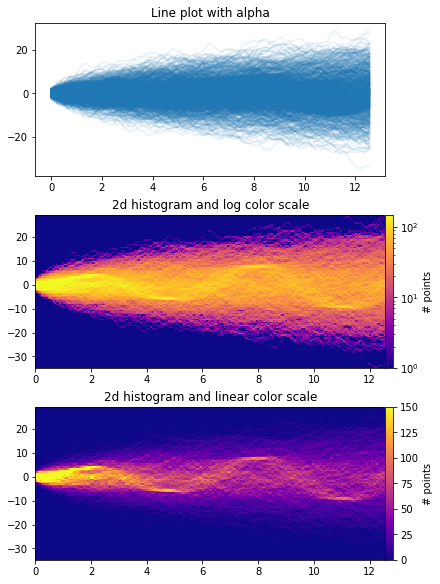

In [1]:
from copy import copy
import time

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(nrows=3, figsize=(6, 8), constrained_layout=True)

# Make some data; a 1D random walk + small fraction of sine waves
num_series = 1000
num_points = 100
SNR = 0.10  # Signal to Noise Ratio
x = np.linspace(0, 4 * np.pi, num_points)
# Generate unbiased Gaussian random walks
Y = np.cumsum(np.random.randn(num_series, num_points), axis=-1)
# Generate sinusoidal signals
num_signal = int(round(SNR * num_series))
phi = (np.pi / 8) * np.random.randn(num_signal, 1)  # small random offset
Y[-num_signal:] = (
    np.sqrt(np.arange(num_points))[None, :]  # random walk RMS scaling factor
    * (np.sin(x[None, :] - phi)
       + 0.05 * np.random.randn(num_signal, num_points))  # small random noise
)


# Plot series using `plot` and a small value of `alpha`. With this view it is
# very difficult to observe the sinusoidal behavior because of how many
# overlapping series there are. It also takes a bit of time to run because so
# many individual artists need to be generated.
tic = time.time()
axes[0].plot(x, Y.T, color="C0", alpha=0.1)
toc = time.time()
axes[0].set_title("Line plot with alpha")
print(f"{toc-tic:.3f} sec. elapsed")


# Now we will convert the multiple time series into a histogram. Not only will
# the hidden signal be more visible, but it is also a much quicker procedure.
tic = time.time()
# Linearly interpolate between the points in each time series
num_fine = 800
x_fine = np.linspace(x.min(), x.max(), num_fine)
y_fine = np.empty((num_series, num_fine), dtype=float)
for i in range(num_series):
    y_fine[i, :] = np.interp(x_fine, x, Y[i, :])
y_fine = y_fine.flatten()
x_fine = np.matlib.repmat(x_fine, num_series, 1).flatten()


# Plot (x, y) points in 2d histogram with log colorscale
# It is pretty evident that there is some kind of structure under the noise
# You can tune vmax to make signal more visible
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))
h, xedges, yedges = np.histogram2d(x_fine, y_fine, bins=[400, 100])
pcm = axes[1].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmax=1.5e2), rasterized=True)
fig.colorbar(pcm, ax=axes[1], label="# points", pad=0)
axes[1].set_title("2d histogram and log color scale")

# Same data but on linear color scale
pcm = axes[2].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         vmax=1.5e2, rasterized=True)
fig.colorbar(pcm, ax=axes[2], label="# points", pad=0)
axes[2].set_title("2d histogram and linear color scale")

toc = time.time()
print(f"{toc-tic:.3f} sec. elapsed")
plt.show()